# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

### To think about

Here are a few things to think and try out about before the next laboratory.

1. Is looking at the max logit the *best* we can do using *just* the CNN outputs? Is there maybe a better way to try to gauge model *confidence* from the logits?

2. Does the behavior of the network on OOD data get *better* or *worse* with more (or fewer) training epochs?

2. Does the problem get worse if we test using *real* images as OOD samples? Find a subset of CIFAR-100 classes that are *distinct* from those in CIFAR-10 and test this theory.


In [15]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torch.utils.data import Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
import random
import gc

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 4 if device == 'cpu' else 8

In [17]:
def train_epoch(model, dataloader, criterion, optimizer, epoch='Unknown', device='cpu', fully_conv=False):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if fully_conv:
            _, _, a, b = outputs.shape
            gts = labels.unsqueeze(-1).unsqueeze(-1).repeat(1,a,b)
            loss = criterion(outputs, gts)
        else:
          loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    return avg_loss


def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.eval()
    losses = []
    predictions = []
    gts = []
    with torch.no_grad():
        for (inputs, labels) in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            gts.append(labels.cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())
            losses.append(loss.item())
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(np.hstack(gts), np.hstack(predictions))
    report = classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3)
    return avg_loss, accuracy, report


def plot_validation_curves(losses_and_accs, fig_path):
    train_losses = [x for (x, _, _) in losses_and_accs]
    val_losses = [x for (_, x, _) in losses_and_accs]
    accs = [x for (_, _, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {round(np.max(accs), 2)} @ epoch {np.argmax(accs)}')
    plt.savefig(fig_path)

In [18]:
ood = 'fakedata'

In [19]:
ood = 'cifar100'

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

id_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

if ood == 'fakedata':
  fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
  fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

if ood == 'cifar100':
  ood_classes = ["aquarium", "bycicle", "bottle", "bed", "rocket", "can", "girl", "chair"]
  cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
  selected_indices = [i for i, (_, label) in enumerate(cifar100) if cifar100.classes[label] in ood_classes]
  fakeset = Subset(cifar100, selected_indices)
  fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified


## Architecture

In [21]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
model = CNN().to(device)
loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
epochs = 50
for e in range(epochs):
    train_epoch(model, trainloader, loss, optimizer, epoch=e, device=device)
    val_loss, val_acc, val_report = evaluate_model(model, testloader, loss, device=device)
    print(f'Epoch {e} - Validation Loss: {val_loss} - Validation Accuracy: {val_acc}')


Training epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 0: 100%|██████████| 196/196 [00:16<00:00, 11.93it/s]


Epoch 0 - Validation Loss: 1.6305077701807023 - Validation Accuracy: 0.4126


Training epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 1: 100%|██████████| 196/196 [00:15<00:00, 12.87it/s]


Epoch 1 - Validation Loss: 1.475444719195366 - Validation Accuracy: 0.4651


Training epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 2: 100%|██████████| 196/196 [00:14<00:00, 13.25it/s]


Epoch 2 - Validation Loss: 1.4275841236114502 - Validation Accuracy: 0.4809


Training epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 3: 100%|██████████| 196/196 [00:15<00:00, 13.01it/s]


Epoch 3 - Validation Loss: 1.3733869165182113 - Validation Accuracy: 0.5015


Training epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 4: 100%|██████████| 196/196 [00:15<00:00, 12.78it/s]


Epoch 4 - Validation Loss: 1.334885036945343 - Validation Accuracy: 0.5237


Training epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 5: 100%|██████████| 196/196 [00:14<00:00, 13.20it/s]


Epoch 5 - Validation Loss: 1.2924160033464431 - Validation Accuracy: 0.533


Training epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 6: 100%|██████████| 196/196 [00:15<00:00, 12.63it/s]


Epoch 6 - Validation Loss: 1.2712357014417648 - Validation Accuracy: 0.5469


Training epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 7: 100%|██████████| 196/196 [00:14<00:00, 13.27it/s]


Epoch 7 - Validation Loss: 1.2261399984359742 - Validation Accuracy: 0.561


Training epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 8: 100%|██████████| 196/196 [00:15<00:00, 12.92it/s]


Epoch 8 - Validation Loss: 1.2127803534269332 - Validation Accuracy: 0.5649


Training epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 9: 100%|██████████| 196/196 [00:15<00:00, 12.94it/s]


Epoch 9 - Validation Loss: 1.1756431937217713 - Validation Accuracy: 0.5782


Training epoch 10:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 10: 100%|██████████| 196/196 [00:15<00:00, 12.87it/s]


Epoch 10 - Validation Loss: 1.1417158275842667 - Validation Accuracy: 0.5902


Training epoch 11:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 11: 100%|██████████| 196/196 [00:15<00:00, 12.98it/s]


Epoch 11 - Validation Loss: 1.1277679741382598 - Validation Accuracy: 0.5986


Training epoch 12:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 12: 100%|██████████| 196/196 [00:15<00:00, 12.77it/s]


Epoch 12 - Validation Loss: 1.0964951127767564 - Validation Accuracy: 0.6116


Training epoch 13:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 13: 100%|██████████| 196/196 [00:15<00:00, 12.85it/s]


Epoch 13 - Validation Loss: 1.078531639277935 - Validation Accuracy: 0.6162


Training epoch 14:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 14: 100%|██████████| 196/196 [00:15<00:00, 13.00it/s]


Epoch 14 - Validation Loss: 1.0574156820774079 - Validation Accuracy: 0.6242


Training epoch 15:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 15: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]


Epoch 15 - Validation Loss: 1.0369329467415809 - Validation Accuracy: 0.6347


Training epoch 16:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 16: 100%|██████████| 196/196 [00:19<00:00, 10.27it/s]


Epoch 16 - Validation Loss: 1.015920552611351 - Validation Accuracy: 0.6435


Training epoch 17:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 17: 100%|██████████| 196/196 [00:17<00:00, 11.05it/s]


Epoch 17 - Validation Loss: 1.0199721455574036 - Validation Accuracy: 0.6415


Training epoch 18:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 18: 100%|██████████| 196/196 [00:17<00:00, 10.95it/s]


Epoch 18 - Validation Loss: 0.9834456205368042 - Validation Accuracy: 0.6531


Training epoch 19:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 19: 100%|██████████| 196/196 [00:17<00:00, 11.37it/s]


Epoch 19 - Validation Loss: 0.9780210480093956 - Validation Accuracy: 0.6578


Training epoch 20:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 20: 100%|██████████| 196/196 [00:14<00:00, 13.13it/s]


Epoch 20 - Validation Loss: 0.9648347690701484 - Validation Accuracy: 0.6637


Training epoch 21:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 21: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s]


Epoch 21 - Validation Loss: 0.9468136906623841 - Validation Accuracy: 0.6655


Training epoch 22:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 22: 100%|██████████| 196/196 [00:14<00:00, 13.13it/s]


Epoch 22 - Validation Loss: 0.9432213887572288 - Validation Accuracy: 0.6663


Training epoch 23:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 23: 100%|██████████| 196/196 [00:15<00:00, 12.90it/s]


Epoch 23 - Validation Loss: 0.9400586068630219 - Validation Accuracy: 0.6663


Training epoch 24:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 24: 100%|██████████| 196/196 [00:15<00:00, 12.87it/s]


Epoch 24 - Validation Loss: 0.9215365439653397 - Validation Accuracy: 0.6753


Training epoch 25:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 25: 100%|██████████| 196/196 [00:15<00:00, 12.91it/s]


Epoch 25 - Validation Loss: 0.9089318662881851 - Validation Accuracy: 0.6829


Training epoch 26:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 26: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]


Epoch 26 - Validation Loss: 0.9040310651063919 - Validation Accuracy: 0.6818


Training epoch 27:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 27: 100%|██████████| 196/196 [00:15<00:00, 13.05it/s]


Epoch 27 - Validation Loss: 0.918812544643879 - Validation Accuracy: 0.6786


Training epoch 28:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 28: 100%|██████████| 196/196 [00:15<00:00, 13.03it/s]


Epoch 28 - Validation Loss: 0.9078503131866456 - Validation Accuracy: 0.685


Training epoch 29:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 29: 100%|██████████| 196/196 [00:15<00:00, 12.67it/s]


Epoch 29 - Validation Loss: 0.8810500949621201 - Validation Accuracy: 0.6919


Training epoch 30:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 30: 100%|██████████| 196/196 [00:15<00:00, 12.98it/s]


Epoch 30 - Validation Loss: 0.8861562743782997 - Validation Accuracy: 0.6913


Training epoch 31:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 31: 100%|██████████| 196/196 [00:15<00:00, 12.85it/s]


Epoch 31 - Validation Loss: 0.8825963720679283 - Validation Accuracy: 0.6947


Training epoch 32:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 32: 100%|██████████| 196/196 [00:15<00:00, 12.94it/s]


Epoch 32 - Validation Loss: 0.879017336666584 - Validation Accuracy: 0.6949


Training epoch 33:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 33: 100%|██████████| 196/196 [00:15<00:00, 13.00it/s]


Epoch 33 - Validation Loss: 0.8787316501140594 - Validation Accuracy: 0.6954


Training epoch 34:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 34: 100%|██████████| 196/196 [00:15<00:00, 12.99it/s]


Epoch 34 - Validation Loss: 0.8846622228622436 - Validation Accuracy: 0.694


Training epoch 35:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 35: 100%|██████████| 196/196 [00:14<00:00, 13.11it/s]


Epoch 35 - Validation Loss: 0.8762521788477897 - Validation Accuracy: 0.6944


Training epoch 36:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 36: 100%|██████████| 196/196 [00:15<00:00, 12.74it/s]


Epoch 36 - Validation Loss: 0.8821346551179886 - Validation Accuracy: 0.6987


Training epoch 37:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 37: 100%|██████████| 196/196 [00:15<00:00, 12.87it/s]


Epoch 37 - Validation Loss: 0.8602658241987229 - Validation Accuracy: 0.7033


Training epoch 38:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 38: 100%|██████████| 196/196 [00:15<00:00, 13.02it/s]


Epoch 38 - Validation Loss: 0.8560155272483826 - Validation Accuracy: 0.7091


Training epoch 39:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 39: 100%|██████████| 196/196 [00:17<00:00, 11.33it/s]


Epoch 39 - Validation Loss: 0.8442002683877945 - Validation Accuracy: 0.7126


Training epoch 40:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 40: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]


Epoch 40 - Validation Loss: 0.8474115654826164 - Validation Accuracy: 0.7126


Training epoch 41:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 41: 100%|██████████| 196/196 [00:16<00:00, 11.84it/s]


Epoch 41 - Validation Loss: 0.8643078669905663 - Validation Accuracy: 0.7109


Training epoch 42:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 42: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]


Epoch 42 - Validation Loss: 0.8522199213504791 - Validation Accuracy: 0.7143


Training epoch 43:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 43: 100%|██████████| 196/196 [00:18<00:00, 10.57it/s]


Epoch 43 - Validation Loss: 0.9056872218847275 - Validation Accuracy: 0.6944


Training epoch 44:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 44: 100%|██████████| 196/196 [00:17<00:00, 10.92it/s]


Epoch 44 - Validation Loss: 0.8932194471359253 - Validation Accuracy: 0.7004


Training epoch 45:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 45: 100%|██████████| 196/196 [00:17<00:00, 11.46it/s]


Epoch 45 - Validation Loss: 0.8700262904167175 - Validation Accuracy: 0.7122


Training epoch 46:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 46: 100%|██████████| 196/196 [00:17<00:00, 10.99it/s]


Epoch 46 - Validation Loss: 0.870763199031353 - Validation Accuracy: 0.716


Training epoch 47:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 47: 100%|██████████| 196/196 [00:17<00:00, 11.30it/s]


Epoch 47 - Validation Loss: 0.8586602985858918 - Validation Accuracy: 0.7192


Training epoch 48:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 48: 100%|██████████| 196/196 [00:16<00:00, 12.09it/s]


Epoch 48 - Validation Loss: 0.8815912947058677 - Validation Accuracy: 0.7156


Training epoch 49:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training epoch 49: 100%|██████████| 196/196 [00:14<00:00, 13.17it/s]
                                                           

Epoch 49 - Validation Loss: 0.8813704043626786 - Validation Accuracy: 0.7147


In [23]:
# PRETRAINED CUSTOM CNN.
model = CNN().to(device)
model.load_state_dict(torch.load('./trained_models/cifar10_cnn.pth', map_location=device)) #50 epochs

<All keys matched successfully>

In [ ]:
# PRETRAINED RESNET
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 47.1MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [14]:
_, test_acc, report = evaluate_model(model, testloader, loss, device=device)
print(f'Test Accuracy: {test_acc}')
print(report)
# CNN 0.7147
# ResNet

Test Accuracy: 0.7147
              precision    recall  f1-score   support

           0      0.731     0.772     0.751      1000
           1      0.850     0.835     0.843      1000
           2      0.595     0.631     0.612      1000
           3      0.557     0.468     0.509      1000
           4      0.645     0.655     0.650      1000
           5      0.560     0.693     0.619      1000
           6      0.806     0.758     0.781      1000
           7      0.803     0.735     0.768      1000
           8      0.787     0.855     0.819      1000
           9      0.860     0.745     0.798      1000

    accuracy                          0.715     10000
   macro avg      0.719     0.715     0.715     10000
weighted avg      0.719     0.715     0.715     10000



## Compute Score

tensor(3, device='cuda:0')


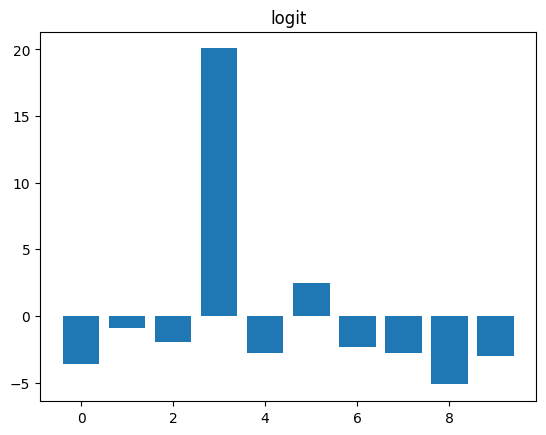

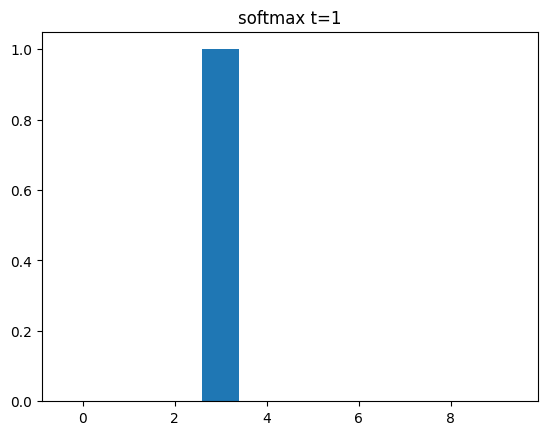

In [ ]:
#Example of logit and softmax output with ID data
x, y = next(iter(testloader))
x, y = x.to(device), y.to(device)
print(y[0])
output = model(x)
plt.bar(np.arange(10),output[0].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[0].detach().cpu())
plt.show()

In [23]:
def max_logit(logit):
    s, _ = logit.max(dim=1) #get the max for each element of the batch
    return s

# (A BASELINE FOR DETECTING MISCLASSIFIED AND OUT-OF-DISTRIBUTION EXAMPLES IN NEURAL NETWORKS, https://arxiv.org/pdf/1610.02136)
def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s, _ = s.max(dim=1) #get the max for each element of the batch
    return s

def compute_scores(data_loader, score_function):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_function(output)
            scores.append(s.cpu())
        scores_t = torch.cat(scores)
        return scores_t


In [34]:
score_function = max_softmax

scores_test = compute_scores(testloader, score_function)
scores_fake = compute_scores(fakeloader, score_function)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


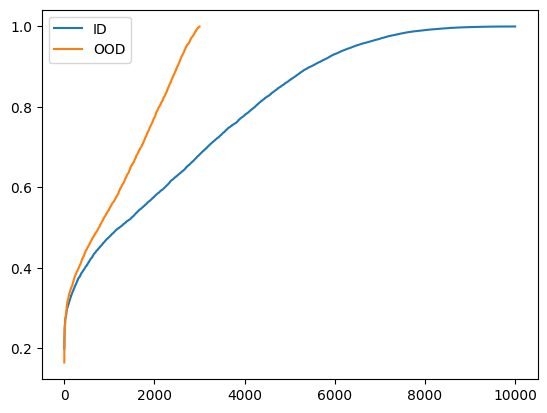

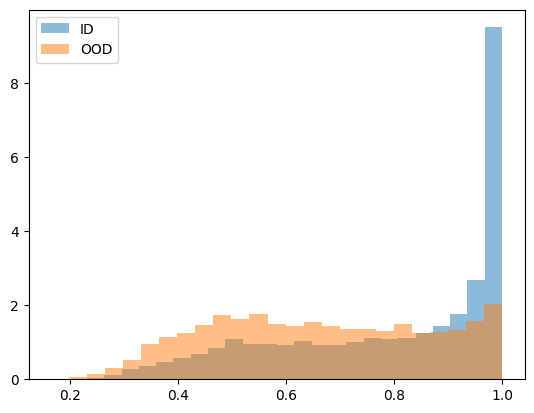

In [35]:
plt.figure()
plt.plot(sorted(scores_test), label='ID')
plt.plot(sorted(scores_fake), label='OOD')
plt.legend()

plt.figure()
plt.hist(scores_test, density=True, alpha=0.5, bins=25, label='ID')
plt.hist(scores_fake, density=True, alpha=0.5, bins=25, label='OOD')
plt.legend()
plt.show()

## Autoencoder MSE

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [ ]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.39966922017688655
1 0.2221485208339837
2 0.20611703608717238
3 0.1982143470371256
4 0.1913501812639285
5 0.184052690787583
6 0.17727649021817712
7 0.17266274456466948
8 0.16983512766203102
9 0.16788785319243157
10 0.16628853718237002
11 0.16474854345528447
12 0.1633074075287702
13 0.16190840281089958
14 0.1605105532371268
15 0.15969771298826957
16 0.1590011543309202
17 0.1583386223231043
18 0.15777625325991182
19 0.15735288504130987


In [ ]:
torch.save(model_ae.state_dict(), './trained_models/cifar10_ae.pth')

In [ ]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)

scores_fake_ae = torch.cat(scores_fake_ae)

scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)

scores_test_ae = torch.cat(scores_test_ae)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


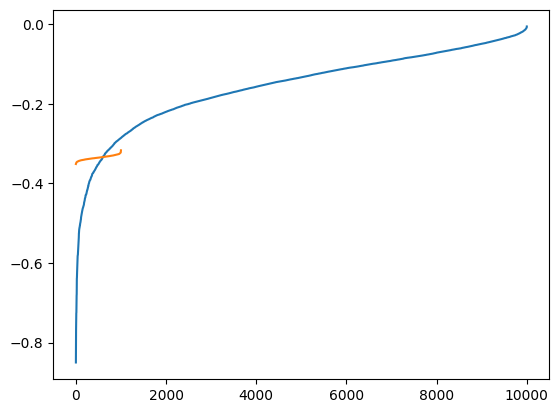

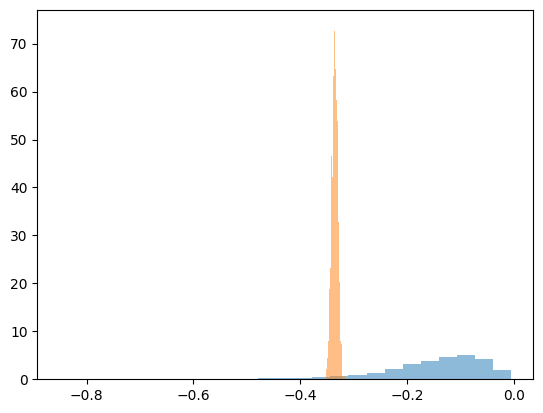

In [ ]:
plt.figure()
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))

plt.figure()
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



AUC ROC: 0.6912194833333333
FPR at 95% TPR: 0.8846666666666667
AUC PRC: 0.8883838977374949
Precision: 0.7692307692307693
Recall: 1.0


'\nAUC ROC: 0.6912194833333333\n'

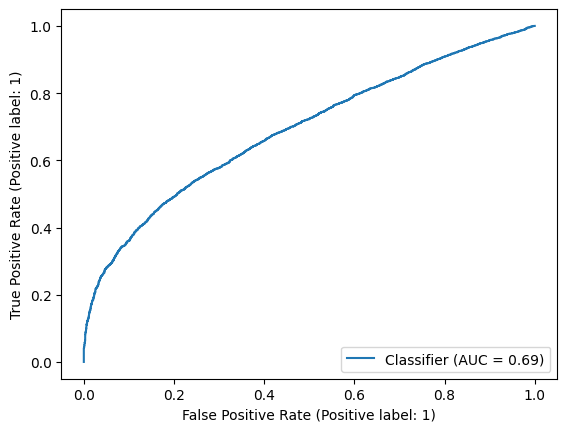

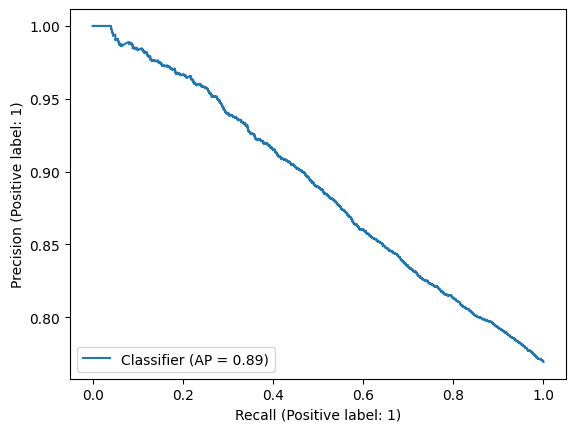

In [37]:
prediction = torch.cat((scores_test, scores_fake))
target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))

fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
auc_score = metrics.auc(fpr, tpr)
print(f'AUC ROC: {auc_score}')
tpr_95_index = np.argmin(np.abs(tpr - 0.95))
fpr_at_95_tpr = fpr[tpr_95_index]
print(f'FPR at 95% TPR: {fpr_at_95_tpr}')
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

precision, recall, _ = metrics.precision_recall_curve(target.cpu().numpy(), prediction.cpu().numpy())
print(f'AUC PRC: {metrics.auc(recall, precision)}')
print(f'Precision: {precision[recall.argmax()]}')
print(f'Recall: {recall[recall.argmax()]}')
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

# CIFAR-100
'''
CNN
AUC ROC: 0.6912194833333333
FPR at 95% TPR: 0.8846666666666667
AUC PRC: 0.8883838977374949

RESNET

AUTOENCODER
'''

# FAKE

'''
CNN


RESNET


AUTOENCODER
AUC baseline: 0.9406555000000001
FPR at 95% TPR: 0.999
AUC PRC: 0.9944368891345501
'''

AUC baseline: 0.9406555000000001
FPR at 95% TPR: 0.999
AUC OOD: 0.9944368891345501
Precision: 0.9090909090909091
Recall: 1.0


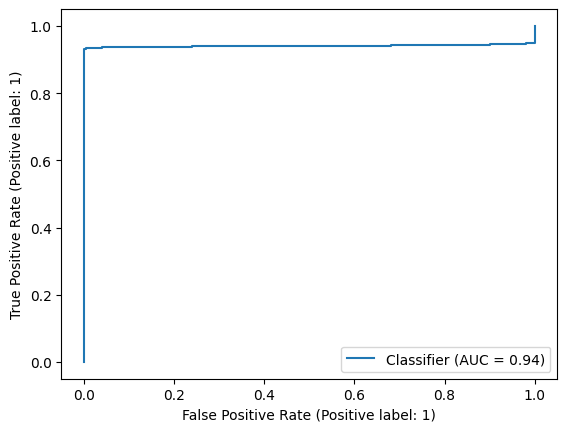

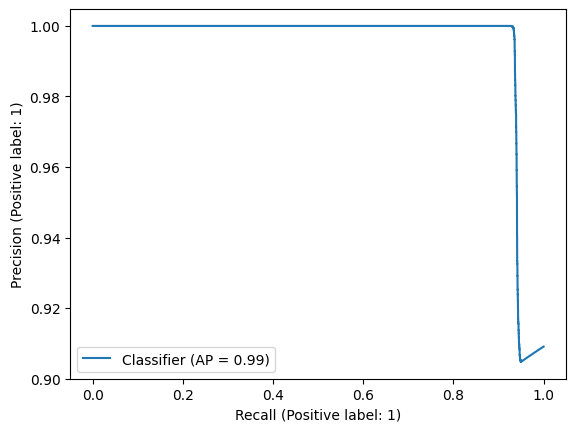

In [ ]:
prediction = torch.cat((scores_test_ae, scores_fake_ae))
target = torch.cat((torch.ones_like(scores_test_ae), torch.zeros_like(scores_fake_ae)))

fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
auc_score = metrics.auc(fpr, tpr)
print(f'AUC baseline: {auc_score}')
tpr_95_index = np.argmin(np.abs(tpr - 0.95))
fpr_at_95_tpr = fpr[tpr_95_index]
print(f'FPR at 95% TPR: {fpr_at_95_tpr}')
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

precision, recall, _ = metrics.precision_recall_curve(target.cpu().numpy(), prediction.cpu().numpy())
print(f'AUC OOD: {metrics.auc(recall, precision)}')
print(f'Precision: {precision[recall.argmax()]}')
print(f'Recall: {recall[recall.argmax()]}')
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [39]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [41]:
def fgsm_attack(model, criterion, image, label, epsilon, max_iter=100):
    orig_img = image.clone().detach()
    perturb_img = image.clone().detach().requires_grad_(True)

    output = model(perturb_img.unsqueeze(0))
    if output.argmax().item() != label.item():
        return 0, orig_img, perturb_img.detach(), output.argmax().item()
    for i in range(max_iter + 1):
        output = model(perturb_img.unsqueeze(0))
        loss = criterion(output, label.unsqueeze(0))
        pred = output.argmax().item()
        if pred != label.item():
            return i, orig_img, perturb_img.detach(), pred

        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturb_img += epsilon * torch.sign(perturb_img.grad)

        perturb_img.requires_grad_(True)

    return None, orig_img, perturb_img.detach(), pred


def show_attack(orig_img, label, adv_img, pred, num_iter, inv, classes):
    if num_iter == None:
        print('Attack Failed!')
    elif num_iter == 0:
        print('Already misclassified!')
    else:
        print(f'Attack Success!')
        print(f'Iteration: {num_iter}')
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(inv(orig_img).permute(1,2,0).detach().cpu())
        ax[0].set_title(f'Original - {classes[label]}')
        ax[1].imshow(inv(adv_img).permute(1,2,0).detach().cpu())
        ax[1].set_title(f'Adversarial - {classes[pred]}')
        ax[2].imshow(inv(orig_img-adv_img).permute(1,2,0).detach().cpu())
        ax[2].set_title('Difference')
        plt.show()


Attack Success!
Iteration: 13


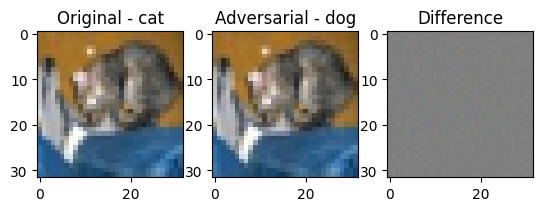

Attack Success!
Iteration: 9


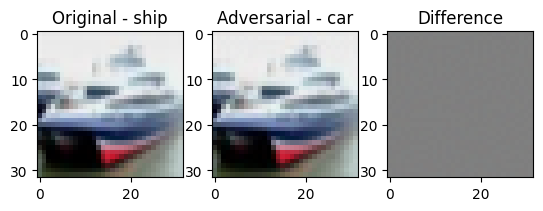

Already misclassified!


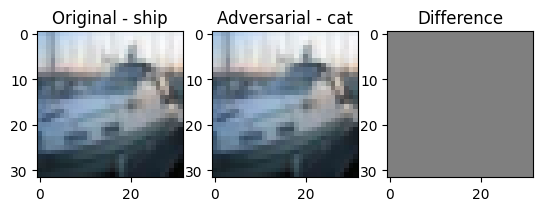

Attack Success!
Iteration: 1


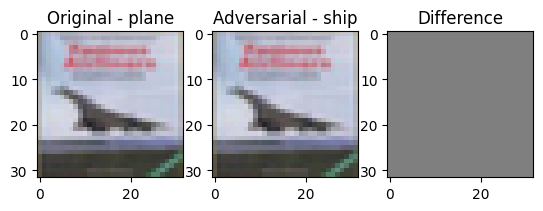

Attack Success!
Iteration: 8


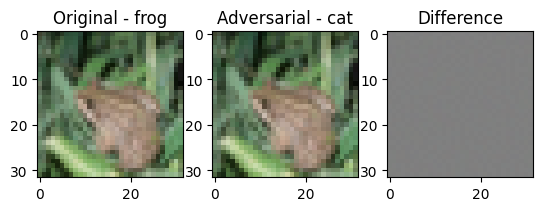

Attack Success!
Iteration: 1


KeyboardInterrupt: 

In [ ]:
epsilon = 0.001
batch_size = 16
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model.eval()

img, label = next(iter(testloader))
for i in range(batch_size):
    img_ex, label_ex = img[i].to(device), label[i].to(device)
    num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img_ex, label_ex, epsilon)
    show_attack(orig_img, label_ex, adv_img, pred, num_iter, inv, classes)


In [42]:
# EVALUATE ASR VERSUS EPSILON
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_eps = []
for epsilon in epsilons:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=1)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_eps.append(num_success/num_attacks)
    print(f'Epsilon: {epsilon} - Attack Success Rate: {num_success/num_attacks}')


Files already downloaded and verified
Epsilon: 0.001 - Attack Success Rate: 0.030789825970548863
Epsilon: 0.005 - Attack Success Rate: 0.12605042016806722
Epsilon: 0.01 - Attack Success Rate: 0.2751031636863824
Epsilon: 0.02 - Attack Success Rate: 0.5319148936170213
Epsilon: 0.05 - Attack Success Rate: 0.8843441466854725
Epsilon: 0.1 - Attack Success Rate: 0.9817415730337079


In [43]:
#EVALUATE ASR VERSUS MAX ITERATIONS
epsilon = 0.001
max_iters = [1, 5, 10, 20, 50]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_iters = []
for max_iter in max_iters:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=max_iter)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_iters.append(num_success/num_attacks)
    print(f'Max Iters: {max_iter} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified
Epsilon: 0.001 - Attack Success Rate: 0.02145922746781116
Epsilon: 0.001 - Attack Success Rate: 0.1643059490084986
Epsilon: 0.001 - Attack Success Rate: 0.28005657708628007
Epsilon: 0.001 - Attack Success Rate: 0.5463483146067416
Epsilon: 0.001 - Attack Success Rate: 0.9516358463726885


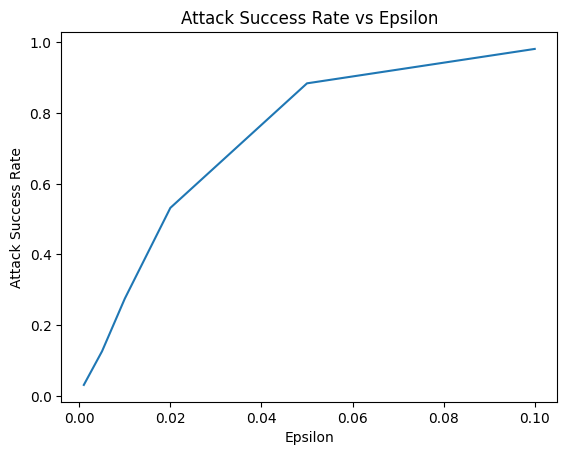

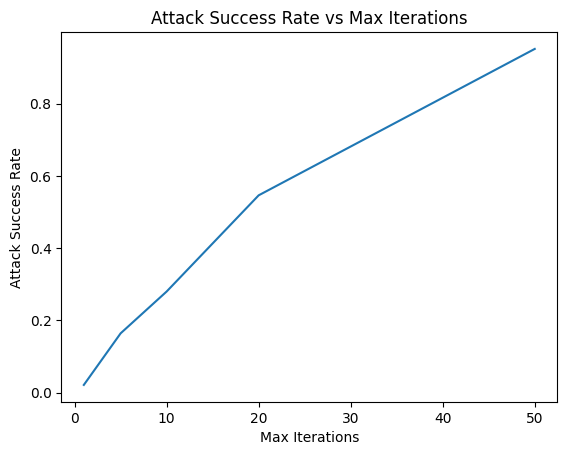

In [44]:
plt.figure()
plt.plot(epsilons, asr_eps)
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Epsilon')

plt.figure()
plt.plot(max_iters, asr_iters)
plt.xlabel('Max Iterations')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Max Iterations')
plt.show()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [38]:
def train_epoch_adv(model, dataloader, loss_fn, optimizer, epoch=0, device='cpu', epsilon=0.01):
  model.train()
  train_loss = []
  bar = tqdm(dataloader, total=len(dataloader))

  for i, (x, y) in enumerate(bar):
    x, y = x.to(device), y.to(device)

    #generate adversarial examples
    x_adv = x.clone().detach().requires_grad_(True)
    for _ in range(1):
      output = model(x_adv)
      loss = loss_fn(output, y)
      model.zero_grad()
      loss.backward()
      with torch.no_grad():
        x_adv += epsilon * torch.sign(x_adv.grad)
      x_adv.requires_grad_(True)

    #train on adversarial examples
    optimizer.zero_grad()
    output_adv = model(x_adv.detach())
    loss_adv = loss_fn(output_adv, y)
    loss_adv.backward()
    optimizer.step()

    #train on original data
    optimizer.zero_grad()
    output = model(x)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    bar.set_description(f"Epoch {epoch} loss: {np.mean(train_loss):.5f}")
  return np.mean(train_loss)


In [45]:
#train the model with adversarial training
model = CNN().to(device)
loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50
epsilon = 0.01

for e in range(epochs):
  train_loss = train_epoch_adv(model, trainloader, loss, optimizer, epoch=e, device=device, epsilon=epsilon)
  val_loss, val_acc, val_report = evaluate_model(model, testloader, loss, device=device)
  print(f'Epoch {e} - Validation Loss: {val_loss} - Validation Accuracy: {val_acc}')

  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 0 loss: 1.80059: 100%|██████████| 196/196 [00:17<00:00, 11.45it/s]


Epoch 0 - Validation Loss: 1.571051925420761 - Validation Accuracy: 0.435


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1 loss: 1.45477: 100%|██████████| 196/196 [00:15<00:00, 12.34it/s]


Epoch 1 - Validation Loss: 1.397673836350441 - Validation Accuracy: 0.4907


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2 loss: 1.35132: 100%|██████████| 196/196 [00:17<00:00, 11.47it/s]


Epoch 2 - Validation Loss: 1.3417417034506798 - Validation Accuracy: 0.521


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3 loss: 1.27510: 100%|██████████| 196/196 [00:17<00:00, 11.13it/s]


Epoch 3 - Validation Loss: 1.2596933871507645 - Validation Accuracy: 0.5477


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4 loss: 1.20009: 100%|██████████| 196/196 [00:17<00:00, 11.03it/s]


Epoch 4 - Validation Loss: 1.2025881290435791 - Validation Accuracy: 0.5685


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5 loss: 1.12984: 100%|██████████| 196/196 [00:17<00:00, 11.19it/s]


Epoch 5 - Validation Loss: 1.1296120136976242 - Validation Accuracy: 0.6005


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6 loss: 1.06694: 100%|██████████| 196/196 [00:17<00:00, 11.19it/s]


Epoch 6 - Validation Loss: 1.1141430154442786 - Validation Accuracy: 0.6069


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7 loss: 1.00573: 100%|██████████| 196/196 [00:17<00:00, 11.09it/s]


Epoch 7 - Validation Loss: 1.067837417125702 - Validation Accuracy: 0.6221


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8 loss: 0.95623: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]


Epoch 8 - Validation Loss: 1.0414682894945144 - Validation Accuracy: 0.6352


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9 loss: 0.90849: 100%|██████████| 196/196 [00:17<00:00, 11.02it/s]


Epoch 9 - Validation Loss: 1.0056679382920266 - Validation Accuracy: 0.649


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10 loss: 0.86832: 100%|██████████| 196/196 [00:17<00:00, 10.94it/s]


Epoch 10 - Validation Loss: 0.9683914840221405 - Validation Accuracy: 0.6622


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11 loss: 0.82674: 100%|██████████| 196/196 [00:17<00:00, 11.25it/s]


Epoch 11 - Validation Loss: 0.9765046551823616 - Validation Accuracy: 0.6533


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12 loss: 0.78524: 100%|██████████| 196/196 [00:17<00:00, 11.03it/s]


Epoch 12 - Validation Loss: 0.9599667549133301 - Validation Accuracy: 0.6639


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13 loss: 0.74697: 100%|██████████| 196/196 [00:17<00:00, 11.26it/s]


Epoch 13 - Validation Loss: 0.9308433786034584 - Validation Accuracy: 0.6734


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14 loss: 0.70676: 100%|██████████| 196/196 [00:16<00:00, 12.16it/s]


Epoch 14 - Validation Loss: 0.921956966817379 - Validation Accuracy: 0.6772


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15 loss: 0.67114: 100%|██████████| 196/196 [00:17<00:00, 11.09it/s]


Epoch 15 - Validation Loss: 0.9089940279722214 - Validation Accuracy: 0.6849


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16 loss: 0.62963: 100%|██████████| 196/196 [00:17<00:00, 11.07it/s]


Epoch 16 - Validation Loss: 0.9184973120689393 - Validation Accuracy: 0.6798


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17 loss: 0.59445: 100%|██████████| 196/196 [00:17<00:00, 11.15it/s]


Epoch 17 - Validation Loss: 0.9041802987456322 - Validation Accuracy: 0.6897


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18 loss: 0.55748: 100%|██████████| 196/196 [00:17<00:00, 11.07it/s]


Epoch 18 - Validation Loss: 0.9020406514406204 - Validation Accuracy: 0.6923


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19 loss: 0.51998: 100%|██████████| 196/196 [00:17<00:00, 11.00it/s]


Epoch 19 - Validation Loss: 0.910450978577137 - Validation Accuracy: 0.6951


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20 loss: 0.48025: 100%|██████████| 196/196 [00:18<00:00, 10.75it/s]


Epoch 20 - Validation Loss: 0.9403316780924798 - Validation Accuracy: 0.6791


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 21 loss: 0.44425: 100%|██████████| 196/196 [00:18<00:00, 10.50it/s]


Epoch 21 - Validation Loss: 0.9300609797239303 - Validation Accuracy: 0.6925


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 22 loss: 0.40704: 100%|██████████| 196/196 [00:17<00:00, 11.01it/s]


Epoch 22 - Validation Loss: 0.9164020866155624 - Validation Accuracy: 0.7021


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 23 loss: 0.36938: 100%|██████████| 196/196 [00:17<00:00, 10.91it/s]


Epoch 23 - Validation Loss: 0.982069942355156 - Validation Accuracy: 0.6895


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 24 loss: 0.33366: 100%|██████████| 196/196 [00:17<00:00, 10.91it/s]


Epoch 24 - Validation Loss: 0.9571496322751045 - Validation Accuracy: 0.6994


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 25 loss: 0.30261: 100%|██████████| 196/196 [00:17<00:00, 10.93it/s]


Epoch 25 - Validation Loss: 0.9917260974645614 - Validation Accuracy: 0.6941


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 26 loss: 0.26541: 100%|██████████| 196/196 [00:16<00:00, 11.62it/s]


Epoch 26 - Validation Loss: 1.0055182144045829 - Validation Accuracy: 0.6978


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 27 loss: 0.23260: 100%|██████████| 196/196 [00:17<00:00, 11.22it/s]


Epoch 27 - Validation Loss: 1.023854035139084 - Validation Accuracy: 0.7004


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 28 loss: 0.20278: 100%|██████████| 196/196 [00:17<00:00, 11.04it/s]


Epoch 28 - Validation Loss: 1.0667957067489624 - Validation Accuracy: 0.6989


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 29 loss: 0.17219: 100%|██████████| 196/196 [00:17<00:00, 11.04it/s]


Epoch 29 - Validation Loss: 1.1093633219599723 - Validation Accuracy: 0.6942


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 30 loss: 0.14641: 100%|██████████| 196/196 [00:17<00:00, 11.17it/s]


Epoch 30 - Validation Loss: 1.160266649723053 - Validation Accuracy: 0.6953


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 31 loss: 0.12453: 100%|██████████| 196/196 [00:17<00:00, 11.16it/s]


Epoch 31 - Validation Loss: 1.2260659158229827 - Validation Accuracy: 0.6915


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 32 loss: 0.10259: 100%|██████████| 196/196 [00:16<00:00, 11.61it/s]


Epoch 32 - Validation Loss: 1.2531985342502594 - Validation Accuracy: 0.6959


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 33 loss: 0.08199: 100%|██████████| 196/196 [00:16<00:00, 11.99it/s]


Epoch 33 - Validation Loss: 1.2903995096683503 - Validation Accuracy: 0.6965


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 34 loss: 0.06429: 100%|██████████| 196/196 [00:17<00:00, 11.10it/s]


Epoch 34 - Validation Loss: 1.3928128331899643 - Validation Accuracy: 0.6916


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 35 loss: 0.05221: 100%|██████████| 196/196 [00:17<00:00, 11.18it/s]


Epoch 35 - Validation Loss: 1.5000899970531463 - Validation Accuracy: 0.6861


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 36 loss: 0.04235: 100%|██████████| 196/196 [00:17<00:00, 11.35it/s]


Epoch 36 - Validation Loss: 1.488176527619362 - Validation Accuracy: 0.6944


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 37 loss: 0.03102: 100%|██████████| 196/196 [00:18<00:00, 10.82it/s]


Epoch 37 - Validation Loss: 1.5898412495851517 - Validation Accuracy: 0.6945


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 38 loss: 0.02453: 100%|██████████| 196/196 [00:17<00:00, 11.22it/s]


Epoch 38 - Validation Loss: 1.6624591767787933 - Validation Accuracy: 0.6916


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 39 loss: 0.01791: 100%|██████████| 196/196 [00:17<00:00, 11.16it/s]


Epoch 39 - Validation Loss: 1.7054887980222702 - Validation Accuracy: 0.6894


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 40 loss: 0.01433: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]


Epoch 40 - Validation Loss: 1.8092976957559586 - Validation Accuracy: 0.6903


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 41 loss: 0.01095: 100%|██████████| 196/196 [00:17<00:00, 11.25it/s]


Epoch 41 - Validation Loss: 1.8588307708501817 - Validation Accuracy: 0.6885


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 42 loss: 0.00795: 100%|██████████| 196/196 [00:17<00:00, 11.12it/s]


Epoch 42 - Validation Loss: 1.9204402089118957 - Validation Accuracy: 0.6886


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 43 loss: 0.00583: 100%|██████████| 196/196 [00:17<00:00, 11.15it/s]


Epoch 43 - Validation Loss: 2.021424722671509 - Validation Accuracy: 0.6864


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 44 loss: 0.00516: 100%|██████████| 196/196 [00:17<00:00, 11.07it/s]


Epoch 44 - Validation Loss: 2.027330458164215 - Validation Accuracy: 0.6939


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 45 loss: 0.00382: 100%|██████████| 196/196 [00:17<00:00, 11.15it/s]


Epoch 45 - Validation Loss: 2.092621976137161 - Validation Accuracy: 0.6887


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 46 loss: 0.00274: 100%|██████████| 196/196 [00:16<00:00, 11.95it/s]


Epoch 46 - Validation Loss: 2.170656922459602 - Validation Accuracy: 0.6908


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 47 loss: 0.00218: 100%|██████████| 196/196 [00:17<00:00, 11.16it/s]


Epoch 47 - Validation Loss: 2.2335465133190153 - Validation Accuracy: 0.6883


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 48 loss: 0.00221: 100%|██████████| 196/196 [00:17<00:00, 11.08it/s]


Epoch 48 - Validation Loss: 2.2940729707479477 - Validation Accuracy: 0.6872


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 49 loss: 0.00245: 100%|██████████| 196/196 [00:17<00:00, 10.95it/s]
                                                           

Epoch 49 - Validation Loss: 2.28352033495903 - Validation Accuracy: 0.6884


In [46]:
torch.save(model.state_dict(), './trained_models/cifar10_cnn_adv.pth')

In [47]:
# EVALUATE ASR VERSUS EPSILON
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_eps_adv = []
for epsilon in epsilons:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=1)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_eps_adv.append(num_success/num_attacks)
    print(f'Epsilon: {epsilon} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epsilon: 0.001 - Attack Success Rate: 0.015895953757225433
Epsilon: 0.005 - Attack Success Rate: 0.10953058321479374
Epsilon: 0.01 - Attack Success Rate: 0.2233285917496444
Epsilon: 0.02 - Attack Success Rate: 0.4014285714285714
Epsilon: 0.05 - Attack Success Rate: 0.7406340057636888
Epsilon: 0.1 - Attack Success Rate: 0.875


In [48]:
#EVALUATE ASR VERSUS MAX ITERATIONS
epsilon = 0.001
max_iters = [1, 5, 10, 20, 50]
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asr_iters_adv = []
for max_iter in max_iters:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 1000))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img, label, epsilon, max_iter=max_iter)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asr_iters_adv.append(num_success/num_attacks)
    print(f'Max Iterations: {max_iter} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max Iterations: 1 - Attack Success Rate: 0.023633677991137372
Max Iterations: 5 - Attack Success Rate: 0.10241820768136557
Max Iterations: 10 - Attack Success Rate: 0.212298682284041
Max Iterations: 20 - Attack Success Rate: 0.41944847605224966
Max Iterations: 50 - Attack Success Rate: 0.8269794721407625


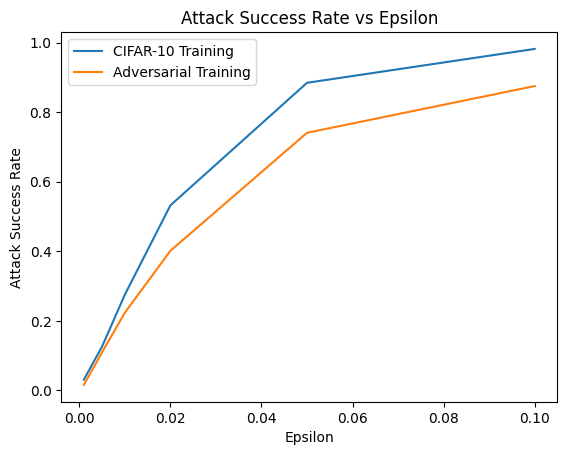

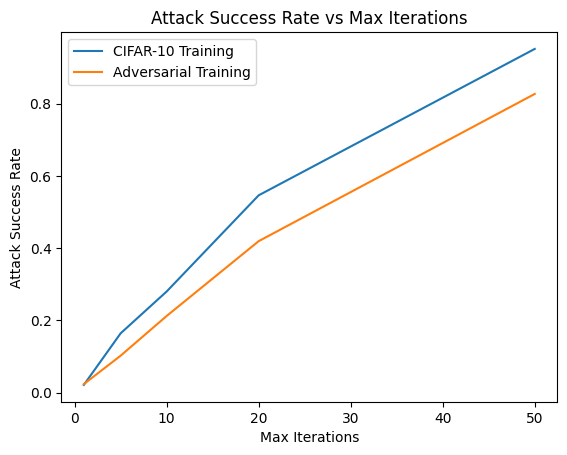

In [49]:
plt.figure()
plt.plot(epsilons, asr_eps, label='CIFAR-10 Training')
plt.plot(epsilons, asr_eps_adv, label='Adversarial Training')
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Epsilon')
plt.legend()

plt.figure()
plt.plot(max_iters, asr_iters, label='CIFAR-10 Training')
plt.plot(max_iters, asr_iters_adv, label='Adversarial Training')
plt.xlabel('Max Iterations')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Max Iterations')
plt.legend()
plt.show()

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

In [37]:
# Implementation of ODIN

class Odin():
    def __init__(self, model, temperature=1, epsilon=0.01):
        self.model = model
        self.temperature = temperature
        self.epsilon = epsilon

    def __call__(self, inputs):
        return self.detect(inputs)

    def set_temperature(self, temperature):
        self.temperature = temperature

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def input_preprocessing(self, inputs, gradient):
        return inputs - self.epsilon * gradient.sign()

    def compute_gradient(self, inputs):
        inputs.requires_grad = True
        logits = self.model(inputs)
        logits = logits / self.temperature
        max_logit, _ = torch.max(logits, dim=1)
        model.zero_grad()
        max_logit.backward(torch.ones(max_logit.shape, device=max_logit.device))
        gradient = -inputs.grad
        return gradient

    def compute_scores(self, inputs):
        gradient = self.compute_gradient(inputs)
        gradient = gradient.detach()
        preprocessed_inputs = self.input_preprocessing(inputs, gradient)

        with torch.no_grad():
            logits = model(preprocessed_inputs)
            softmax_scores = F.softmax(logits / self.temperature, dim=1)
            max_softmax_scores, _ = torch.max(softmax_scores, dim=1)

        return max_softmax_scores

    def detect(self, dataloader):
        scores = []
        model.eval()
        for (x, y) in dataloader:
            x = x.to(device)
            score = self.compute_scores(x)
            scores.append(score.cpu())
            del x, score
            torch.cuda.empty_cache()
            gc.collect()
        scores_t = torch.cat(scores)
        return scores_t

In [38]:
def grid_search(model, testloader, fakeloader, temperatures, epsilons, device='cpu'):
    model.eval()
    odin = Odin(model)
    best_auc = 0
    best_temp = None
    best_eps = None
    for temp in temperatures:
        for eps in epsilons:
            odin.set_temperature(temp)
            odin.set_epsilon(eps)
            scores_test = odin(testloader, model, temp, eps)
            scores_fake = odin(fakeloader, model, temp, eps)
            prediction = torch.cat((scores_test, scores_fake))
            target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))
            fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
            auc_score = metrics.auc(fpr, tpr)
            if auc_score > best_auc:
                print(f'Temperature: {temp}, Epsilon: {eps}, AUC: {auc_score}')
                best_auc = auc_score
                best_temp = temp
                best_eps = eps
    return best_temp, best_eps

In [ ]:
# CIFAR-100
temp = 1000
eps = 0.02

odin = Odin(model, temperature=temp, epsilon=eps)
scores_test = odin(testloader)
scores_fake = odin(fakeloader)

AUC ROC: 0.75139405
FPR at 95% TPR: 0.804
AUC PRC: 0.9088881874811742
Precision: 0.7692307692307693
Recall: 1.0


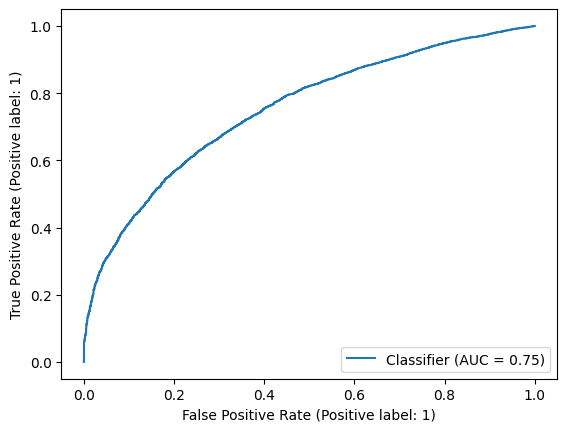

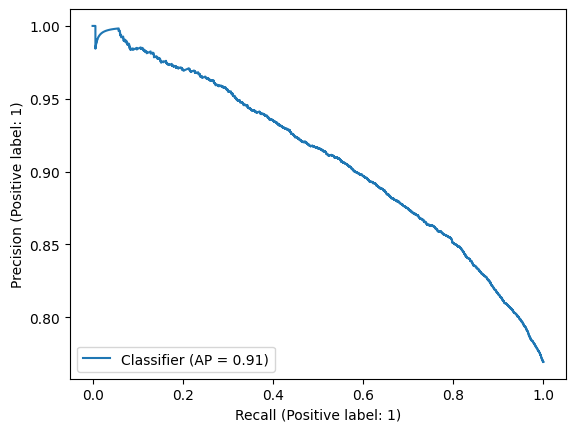

In [40]:
prediction = torch.cat((scores_test, scores_fake))
target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))
fpr, tpr, _ = metrics.roc_curve(target.cpu().numpy(), prediction.cpu().numpy())
auc_score = metrics.auc(fpr, tpr)
print(f'AUC ROC: {auc_score}')
tpr_95_index = np.argmin(np.abs(tpr - 0.95))
fpr_at_95_tpr = fpr[tpr_95_index]
print(f'FPR at 95% TPR: {fpr_at_95_tpr}')
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

precision, recall, _ = metrics.precision_recall_curve(target.cpu().numpy(), prediction.cpu().numpy())
print(f'AUC PRC: {metrics.auc(recall, precision)}')
print(f'Precision: {precision[recall.argmax()]}')
print(f'Recall: {recall[recall.argmax()]}')
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

# CIFAR-100
'''
CNN
AUC ROC: 0.75139405
FPR at 95% TPR: 0.804
AUC PRC: 0.9088881874811742
'''

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [41]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [58]:
def fgsm_targeted_attack(model, criterion, image, label, target, epsilon, max_iter=100):
    orig_img = image.clone().detach()
    perturb_img = image.clone().detach().requires_grad_(True)
    target = torch.tensor([target]).to(device)

    if label.item() == target.item():
        return -1, orig_img, perturb_img.detach()

    output = model(perturb_img.unsqueeze(0))
    if output.argmax().item() != label.item():
        return 0, orig_img, perturb_img.detach()
    for i in range(max_iter + 1):
        output = model(perturb_img.unsqueeze(0))
        loss = - criterion(output, target) # Negative Loss between output and target
        if output.argmax().item() == target.item():
            return i, orig_img, perturb_img.detach()

        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturb_img += epsilon * torch.sign(perturb_img.grad)

        perturb_img.requires_grad_(True)

    return None, orig_img, perturb_img.detach()


def show_attack(orig_img, label, adv_img, target, num_iter, inv, classes):
    if num_iter == None:
        print('Attack Failed!')
    elif num_iter == 0:
        print('Already misclassified!')
    elif num_iter == -1:
        print('The target corresponds to the label!')
    else:
        print(f'Attack Success!')
        print(f'Iteration: {num_iter}')
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(inv(orig_img).permute(1,2,0).detach().cpu())
        ax[0].set_title(f'Original - {classes[label]}')
        ax[1].imshow(inv(adv_img).permute(1,2,0).detach().cpu())
        ax[1].set_title(f'Adversarial - {classes[target]}')
        ax[2].imshow(inv(orig_img-adv_img).permute(1,2,0).detach().cpu())
        ax[2].set_title('Difference')
        plt.show()

Already misclassified!


Attack Success!
Iteration: 32


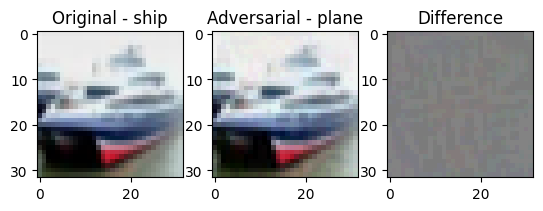

Attack Success!
Iteration: 16


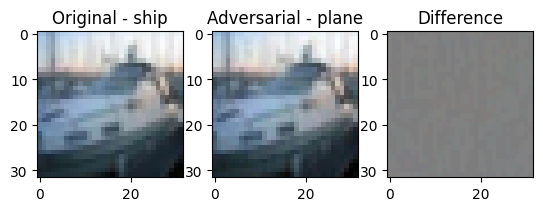

The target corresponds to the label!
Already misclassified!


Attack Success!
Iteration: 44


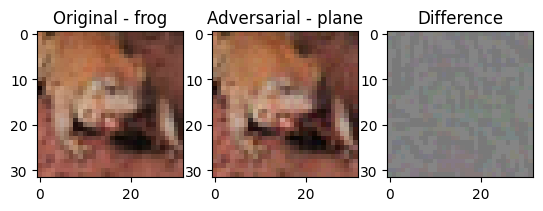

Already misclassified!


Attack Success!
Iteration: 42


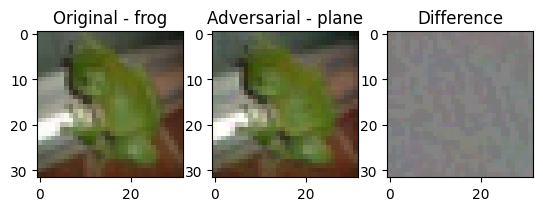

Attack Success!
Iteration: 39


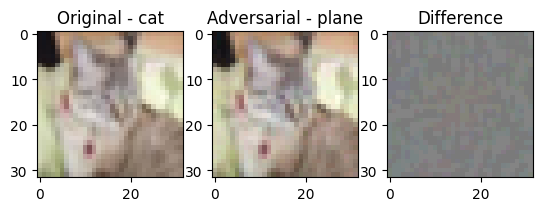

Attack Success!
Iteration: 50


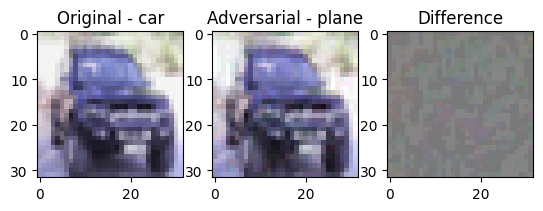

The target corresponds to the label!


Attack Success!
Iteration: 68


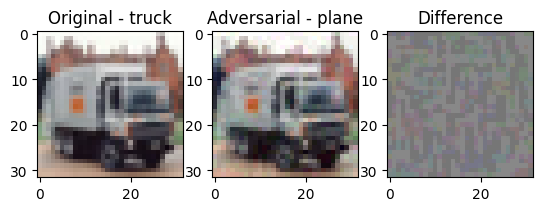

Attack Success!
Iteration: 45


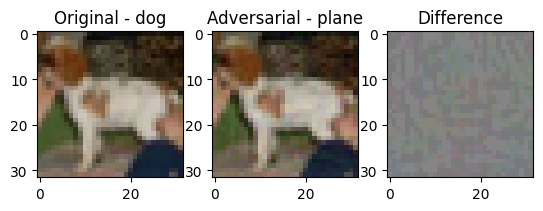

Attack Success!
Iteration: 53


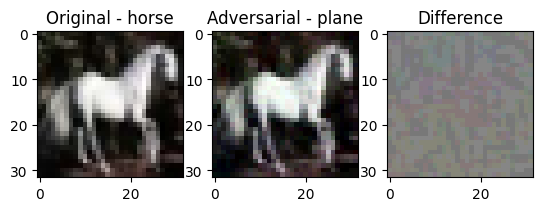

Attack Success!
Iteration: 61


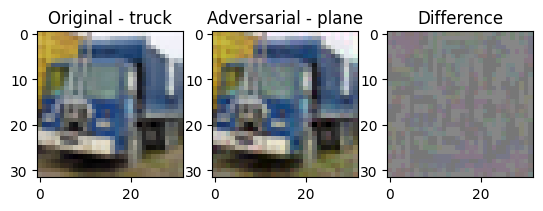

Attack Success!
Iteration: 55


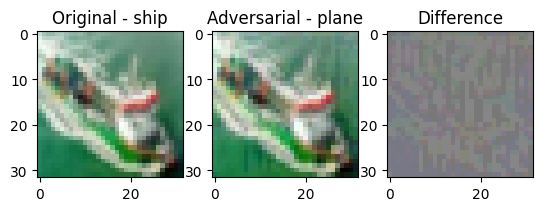

In [60]:
epsilon = 0.001
batch_size = 16
target = 0
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model.eval()

img, label = next(iter(testloader))
for i in range(batch_size):
    img_ex, label_ex = img[i].to(device), label[i].to(device)
    num_iter, orig_img, adv_img = fgsm_targeted_attack(model, criterion, img_ex, label_ex, target, epsilon)
    show_attack(orig_img, label_ex, adv_img, target, num_iter, inv, classes)


In [63]:
# EVALUATE ASR VERSUS EPSILON
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
target = 0
batch_size = 256
model.eval()
criterion = nn.CrossEntropyLoss()
inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

asrt_eps = []
for epsilon in epsilons:
    num_attacks = 0
    num_success = 0
    subset = Subset(testset, random.sample(range(len(testset)), 100))
    subloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for x, y in subloader:
        for img, label in zip(x, y):
            img, label = img.to(device), label.to(device)
            num_iter, orig_img, adv_img = fgsm_targeted_attack(model, criterion, img, label, target, epsilon, max_iter=1)
            if num_iter != 0:
                num_attacks += 1
                if num_iter != None:
                    num_success += 1
    asrt_eps.append(num_success/num_attacks)
    print(f'Epsilon: {epsilon} - Attack Success Rate: {num_success/num_attacks}')

Files already downloaded and verified
Epsilon: 0.001 - Attack Success Rate: 0.14285714285714285
Epsilon: 0.005 - Attack Success Rate: 0.125
Epsilon: 0.01 - Attack Success Rate: 0.3132530120481928
Epsilon: 0.02 - Attack Success Rate: 0.2328767123287671
Epsilon: 0.05 - Attack Success Rate: 0.4666666666666667
Epsilon: 0.1 - Attack Success Rate: 0.6375


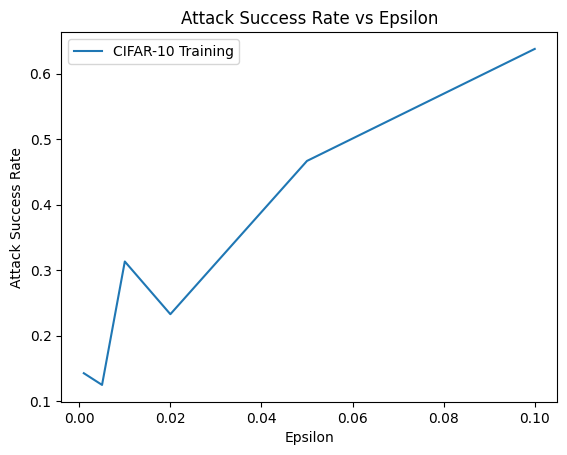

In [64]:
plt.figure()
plt.plot(epsilons, asrt_eps, label='CIFAR-10 Training')
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs Epsilon')
plt.legend()